# Cosine-similarity classifier [PyTorch]
- feature extractor: ConvNet
- classifier: cosine classifier (S. Gidaris et al., 2018)

<b>Goal</b>: See if it can learn the representations effectively.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

import torch
import torch.nn as nn

from torch import relu

from torch.utils.data import DataLoader, Dataset

import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
# GPU settings
device = torch.device(0)
device

device(type='cuda', index=0)

### Few-shot Learning Settings
K-shot N-ways

In [3]:
K = 10
N = 1
left_class = 7

### Get a dataset

In [4]:
data_transform = transforms.Compose([transforms.ToTensor()])

# import the `MNIST datasets`
mnist_train = dsets.MNIST(root='data',
                          train=True,
                          transform=data_transform,
                          download=True)

mnist_test = dsets.MNIST(root='data',
                          train=False,
                          transform=data_transform,
                          download=True)

# build the `DataLoader`
train_data_loader = DataLoader(mnist_train, batch_size=2**9)
test_data_loader = DataLoader(mnist_test, batch_size=mnist_test.data.shape[0])

In [5]:
# Label Encoder
label_encoder  = preprocessing.LabelEncoder()

targets = list(range(0, 10, 1))
targets.pop(left_class)
targets = np.array(targets).reshape(-1, 1)

label_encoder.fit(targets);

C:\Users\Daesoo\AppData\Local\Programs\Python\Python37\venvs\pytorch\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [6]:
for x, y in train_data_loader:
    print(x); print(y); print(x.max()); print(x.shape)
    break

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

### Build a model

In [7]:
class Model(nn.Module):
    def __init__(self, in_size=28, embedding_feature_size=2, n_classes=10):
        super().__init__()
        
        # Data properties
        in_channels = 1
        
        # Define layers
        # 1
        self.conv1 = nn.Conv2d(in_channels, 12, kernel_size=3, padding=1)
        self.bn1 = nn.Dropout(0.2) #nn.BatchNorm2d(12)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2
        self.conv2 = nn.Conv2d(12, 24, kernel_size=3, padding=1)
        self.bn2 = nn.Dropout(0.2) #nn.BatchNorm2d(24)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3
        self.conv3 = nn.Conv2d(24, 48, kernel_size=3, padding=1)
        self.bn3 = nn.Dropout(0.0) #nn.BatchNorm2d(48)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 4
        self.last_embedding_layer = nn.Linear(48*3*3, embedding_feature_size)
        
        # Each `w` is a representation vector of each class.
        self.Wstar_layer = nn.Linear(embedding_feature_size, n_classes, bias=False)  # 'bias=False' allows the weights to be the pure representation vectors (not affected by the bias)
        
    def forward(self, x):
        #============================
        # Feature Extractor
        h1 = self.maxpool1(relu(self.bn1(self.conv1(x))))
        h2 = self.maxpool2(relu(self.bn2(self.conv2(h1))))
        h3 = self.maxpool3(relu(self.bn3(self.conv3(h2))))
        
        batch_size = x.shape[0]
        h3 = h3.view(batch_size, -1)  # 1
        
        self.z = self.last_embedding_layer(h3)
        norm_z = self.z / torch.norm(self.z, p=2, dim=1, keepdim=True)#.detach() # 2)
        
        # 1) flattne layer
        # 2) representation vector of `x`; Note `.detach()`: ; We don't want the l2-norm function to be involved with the gradient descent update.
        
        #============================
        # Cosine-similarity Classifier
        Wstar = self.Wstar_layer.weight.T#.detach()  # Note `.detach()`
        norm_Wstar = Wstar / torch.norm(Wstar, p=2, dim=0, keepdim=True)
        
        cosine_similarities = torch.mm(norm_z, norm_Wstar)
        # Note that `CrossEntropyLoss()` = `LogSoftmax` + `NLLLoss`
        return cosine_similarities
    

In [8]:
model = Model(embedding_feature_size=64, n_classes=9).to(device)

### Compile

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss()

In [10]:
decayRate = 1.0
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, 
                                                         gamma=decayRate)

In [11]:
# temperature parameter
tau = 0.1

study effects of the temperature parameter
- Note that the temperature parameters of 0.1 / 0.2 result in the best performance given the SimCLR and MoCo-v2 papers.

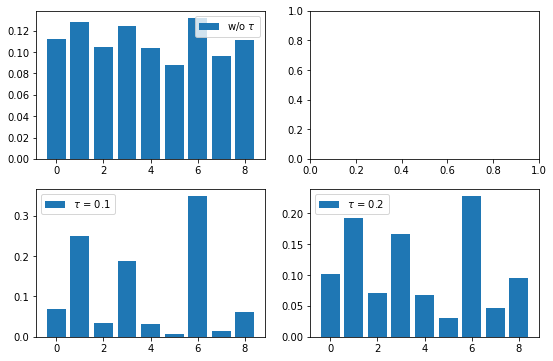

In [12]:
from scipy.special import softmax

yhat = model(x.to(device))
yhat = yhat[0, :].to("cpu").detach().numpy()
x_ = np.arange(yhat.size)

fig, ax = plt.subplots(2, 2, figsize=(9, 6))
ax[0,0].bar(x_, softmax(yhat), label=r"w/o $\tau$"); ax[0,0].legend();
ax[1,0].bar(x_, softmax(yhat/0.1), label=r"$\tau$ = 0.1"); ax[1,0].legend();
ax[1,1].bar(x_, softmax(yhat/0.2), label=r"$\tau$ = 0.2"); ax[1,1].legend();

### Train

In [13]:
# settings
n_epochs = 6

In [14]:
def leave_out_a_class(x, y, left_class):
    "leave out some class for the few-shot learning"
    indices = (y != left_class)
    return x[indices, :, :, :], y[indices]

In [15]:
train_hist = {"epochs": [], "loss_per_epoch": [], "loss": [], "test_acc": []}

for epoch in range(n_epochs):
    model.train()
    
    loss_per_epoch = 0
    iters = 0
    for x, y in train_data_loader:
        x, y = leave_out_a_class(x, y, left_class)
        y = torch.tensor(label_encoder.transform(y))
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        yhat = model(x)
        
        loss = criterion(yhat/tau, y)
        loss.backward()
        
        optimizer.step()
        
        # data storage
        loss_per_epoch += loss
        iters += 1
        train_hist["loss"].append(loss)
        #print(round(loss.item(), 2), end=" ")
            
    train_hist["epochs"].append(epoch)
    train_hist["loss_per_epoch"].append(loss_per_epoch)
    
    # validation
    with torch.no_grad():
        model.eval()
        test_acc = 0
        for x_test, y_test in test_data_loader:
            x_test, y_test = leave_out_a_class(x_test, y_test, left_class)
            y_test = torch.tensor(label_encoder.transform(y_test))
            x_test, y_test = x_test.to(device), y_test.to(device)
            yhat = torch.argmax(model(x_test.to(device)), axis=1)
            test_acc += np.mean((yhat.to("cpu") == y_test.to("cpu")).numpy())
        train_hist["test_acc"].append(test_acc)
    
    my_lr_scheduler.step()
    
    print("epoch: {}, loss: {:0.3f}, test_acc: {:0.3f} | lr: {:0.4f}".format(epoch, loss_per_epoch/iters, test_acc, optimizer.param_groups[0]['lr']))
    

epoch: 0, loss: 0.544, test_acc: 0.972 | lr: 0.0010
epoch: 1, loss: 0.085, test_acc: 0.983 | lr: 0.0010
epoch: 2, loss: 0.066, test_acc: 0.985 | lr: 0.0010
epoch: 3, loss: 0.054, test_acc: 0.986 | lr: 0.0010
epoch: 4, loss: 0.045, test_acc: 0.988 | lr: 0.0010
epoch: 5, loss: 0.038, test_acc: 0.990 | lr: 0.0010


### Make `support set` and `query set`

In [16]:
indices = (mnist_test.targets == left_class)

class SupportSet(Dataset):
    def __init__(self,):
        super().__init__()
        
        support_set_X = []
        support_set_Y = []
        for c in range(0, 10):
            indices = (mnist_test.targets == c)
            support_set_X.append( mnist_test.data[indices, :, :][:N, :, :].numpy() / 255. )
            support_set_Y.append( mnist_test.targets[indices][:N].numpy() )

        self.support_set_X = torch.from_numpy(np.array(support_set_X)).view(N*10, 1, 28, 28)
        self.support_set_Y = torch.from_numpy(np.array(support_set_Y).flatten())

        self.len = self.support_set_X.shape[0]
        
    def __getitem__(self, idx):
        return self.support_set_X[idx], self.support_set_Y[idx]
    
    def __len__(self):
        return self.len

support_set = SupportSet()
support_set_data_loader = DataLoader(support_set, batch_size=2**10)

## Prototype Approach

### Obtain $w_{left-class}$
Note $w_i \in W^*$

In [17]:
with torch.no_grad():
    model.eval()
    avg_z = 0.
    count = 0
    for x, y in support_set:
        if y.item() == left_class:
            enc_yhat = model(x.view(1, 1, 28, 28).to(device, dtype=torch.float))
            avg_z += model.z
            count += 1
    avg_z /= count

In [18]:
avg_z.shape

torch.Size([1, 64])

### Re-establish $W^*$ 
- `model.Wstar_layer.weight`

In [19]:
model.Wstar_layer.weight.shape  # [in, out]

torch.Size([9, 64])

In [20]:
font_Wstar = model.Wstar_layer.weight[:left_class, :]
back_Wstar = model.Wstar_layer.weight[left_class:, :]

print(font_Wstar.shape); print(back_Wstar.shape)

torch.Size([7, 64])
torch.Size([2, 64])


In [21]:
res_Wstar = torch.cat((font_Wstar, avg_z, back_Wstar), 0).to(device)
print(res_Wstar.shape)

torch.Size([10, 64])


In [22]:
# assign the `res_Wstar` to the existing model
model.Wstar_layer.weight = nn.Parameter(res_Wstar)

### Evaluate the learned representations

`left_class` only

In [23]:
with torch.no_grad():
    model.eval()
    
    indices = (mnist_test.targets == left_class)
    
    test_acc = 0
    count = 0
    for x_test, y_test in test_data_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        x_test, y_test = x_test[indices,:,:], y_test[indices]
        
        yhat = torch.argmax(model(x_test.to(device)), axis=1)
        
        test_acc += np.mean((yhat.to("cpu") == y_test.to("cpu")).numpy())
        count += 1
        
    test_acc /= count

In [24]:
test_acc

0.8608949416342413

over all classes

In [25]:
with torch.no_grad():
    model.eval()
    
    test_accs = []
    for c in range(10):
        indices = (mnist_test.targets == c)
    
        test_acc = 0
        count = 0
        for x_test, y_test in test_data_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            x_test, y_test = x_test[indices,:,:], y_test[indices]

            yhat = torch.argmax(model(x_test.to(device)), axis=1)

            test_acc += np.mean((yhat.to("cpu") == y_test.to("cpu")).numpy())
            count += 1

        test_acc /= count
        test_accs.append(test_acc)
        print(f"class: {c} | acc: {round(test_acc, 3)}")

print("\n overall acc: {:0.3f}".format(np.mean(test_accs)))

class: 0 | acc: 0.999
class: 1 | acc: 0.999
class: 2 | acc: 0.978
class: 3 | acc: 0.983
class: 4 | acc: 0.997
class: 5 | acc: 0.992
class: 6 | acc: 0.986
class: 7 | acc: 0.861
class: 8 | acc: 0.975
class: 9 | acc: 0.972

 overall acc: 0.974


<b>Conclusion</b>: With the `temperature`, the quality of the learned representations is much better!

---